## Classificação de sentimentos dos comentários de avaliação de produtos do site Olist

**Resumo**

Esse notebook tem como objetivo construir um **modelo de classificação de sentimento** usando um conjunto de dados não estruturados (*comentários sobre um determinado produto*) para isso, será ultilizado a técnica de extração de feature para aplicar um algortimo de classificação afim de prever sentimentos **positivos** ou **negativos**.

O presente trabalho está dividido nas seguintes etapas:

1. Pré-processamento dos dados
2. Extração de features : Bag of Words e TF-IDF
3. Métricas de classificação
4. Construção de um classificador Naive Bayes
5. Validando o modelo
6. Conclusões finais





Instalação das bibliotecas 

In [ ]:
#instalação da biblioteca- versão 2.2.3
!pip install -q spacy==2.2.3

In [ ]:
#download do pacote em portugues para processamento dos textos
!python3 -m spacy download pt

In [ ]:
#instalação da biblioteca NLTK
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Pré-processamento dos dados

In [ ]:
#importação das bibliotecas
import pandas as pd
import re
import nltk
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import spacy.cli


%matplotlib inline

In [ ]:
spacy.cli.download("pt_core_news_sm") #download de dependencias 

⚠ Skipping model package dependencies and setting `--no-deps`. You
don't seem to have the spaCy package itself installed (maybe because you've
built from source?), so installing the model dependencies would cause spaCy to
be downloaded, which probably isn't what you want. If the model package has
other dependencies, you'll have to install them manually.
✔ Download and installation successful
You can now load the model via spacy.load('pt_core_news_sm')


In [ ]:
import pt_core_news_sm #importando um recurso para trabalhar com textos em pt
spc_pt = pt_core_news_sm.load()

In [ ]:
#usando a função de leitura do pandas para ler dados em formato csv
df = pd.read_csv("/content/drive/MyDrive/dados_desafio/olist_order_reviews_dataset.csv")

In [ ]:
df.head(5) #visualizando as primeiras 5 linhas

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [ ]:
#verificando as colunas do conjunto de dados 
df.columns

Index(['review_id', 'order_id', 'review_score', 'review_comment_title',
       'review_comment_message', 'review_creation_date',
       'review_answer_timestamp'],
      dtype='object')

O nosso foco aqui é utilizar apenas as colunas alvos para trabalhar na nossa análise desse modo, será removida algumas usando a [função drop](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop.html) da biblioteca pandas 

In [ ]:
#dropando as colunas desnecessárias usando a função drop do pandas 
df.drop(['order_id', 'review_creation_date', 'review_answer_timestamp'],
          1, inplace = True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
#verificando as informações do conjunto de dados 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   review_id               99224 non-null  object
 1   review_score            99224 non-null  int64 
 2   review_comment_title    11568 non-null  object
 3   review_comment_message  40977 non-null  object
dtypes: int64(1), object(3)
memory usage: 3.0+ MB


Agora veremos se nosso conjunto de dados tem valores faltantes , valores duplicados para iniciar um tratamento destes mesmos pois é necessário para que o classificador funcione bem.

In [ ]:
#calculando a % de dados duplicados com a função do pandas duplicated()
df_duplicados = round(sum(df.duplicated("review_id"))/len(df)*100, 2)
#imprimindo a %
print(f"Reviews com id duplicado: {df_duplicados}%.")

Reviews com id duplicado: 0.82%.


Conforme é possivel ver acima, temos cerca de **82%** de dados duplicados nesse caso, vamos remover estes e fazer uma limpeza nos dados.

In [ ]:
# removendo os dados duplicados com função drop_duplicates do pandas
df.drop_duplicates("review_id", inplace = True) 
# usando a função fillna para substituição de valores assim, evitaremos problemas 
df.fillna('', inplace = True) 
# concatenando  duas colunas
df['review'] = df['review_comment_title'] + ' ' + df['review_comment_message']
# remoção de  entradas sem texto 
df = df[df['review'] != ' ']

In [ ]:
df.head()

,review_id,review_score,review_comment_title,review_comment_message,review
3,e64fb393e7b32834bb789ff8bb30750e,5,,Recebi bem antes do prazo estipulado.,Recebi bem antes do prazo estipulado.
4,f7c4243c7fe1938f181bec41a392bdeb,5,,Parabéns lojas lannister adorei comprar pela I...,Parabéns lojas lannister adorei comprar pela ...
9,8670d52e15e00043ae7de4c01cc2fe06,4,recomendo,aparelho eficiente. no site a marca do aparelh...,recomendo aparelho eficiente. no site a marca ...
12,4b49719c8a200003f700d3d986ea1a19,4,,"Mas um pouco ,travando...pelo valor ta Boa.\r\n","Mas um pouco ,travando...pelo valor ta Boa.\r\n"
15,3948b09f7c818e2d86c9a546758b2335,5,Super recomendo,"Vendedor confiável, produto ok e entrega antes...","Super recomendo Vendedor confiável, produto ok..."


Realizamos alguns tratamentos iniciais nos dados textuais, agora vamos analisar os escores de avaliação pois eles serão uma variável alvo  

In [ ]:
#contagem de valores usando value_counts
df['review_score'].value_counts()

5    21672
1     8723
4     6241
3     3615
2     2138
Name: review_score, dtype: int64

Vejamos que temos 5 valores de score diferentes portanto, para facilitar na construção do classificador , vamos classificar as avaliações apenas como positiva ou negativa pois o classificador nos retornará esse tipo de informação. 

A **regra condicional** será essa:

Se o score for menor ou igual a 3, será negativo (0) e senão , positivo (1).

In [ ]:
sentimento = [] #lista para armazenamento

for score in df['review_score']: #usando o for para percorrer os nosso escores
  if score > 3: 
    sentimento.append(1) # adicionando 1 para positivo
  else:
    sentimento.append(0) # adicionando 0 para negativo

df['sentimento'] = sentimento # adicionando no dataframe a coluna sentimento

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42389 entries, 3 to 99223
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   review_id               42389 non-null  object
 1   review_score            42389 non-null  int64 
 2   review_comment_title    42389 non-null  object
 3   review_comment_message  42389 non-null  object
 4   review                  42389 non-null  object
 5   sentimento              42389 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 2.3+ MB


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


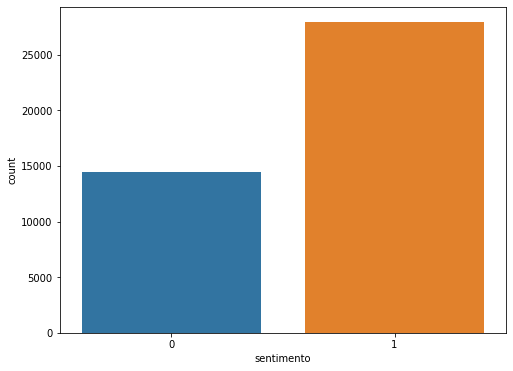

In [ ]:
#plotando um gráfico para visualizar os escores , aqui usamos a biblioteca de visualização de dados seaborn 
plt.figure(figsize=(8,6))
sns.countplot(df['sentimento'])
plt.show()

Observando o **gráfico de barra** acima, é possivel concluir que temos muito mais comentários positivos do que negativos.

# Tratamento dos comentários

Será construida uma função onde esta mesma tem como objetivo fazer uma "higiene nos comentários"

Estrutura da **função limpar_texto** tem os seguintes componentes básicos de NLP  :
* Tornar letras minúsculas
* Limpar nome do usuário (@)
* Remover URLs
* Espaços em branco
* Stop words
* Lematização
* Pontuações

In [ ]:
#baixando e importando o recurso  de stopwords
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:

stopwords_pt = stopwords.words("portuguese")

In [ ]:
#visualizando as stopwords em pt 
stopwords_pt

['de',
 'a',
 'o',
 'que',
 'e',
 'é',
 'do',
 'da',
 'em',
 'um',
 'para',
 'com',
 'não',
 'uma',
 'os',
 'no',
 'se',
 'na',
 'por',
 'mais',
 'as',
 'dos',
 'como',
 'mas',
 'ao',
 'ele',
 'das',
 'à',
 'seu',
 'sua',
 'ou',
 'quando',
 'muito',
 'nos',
 'já',
 'eu',
 'também',
 'só',
 'pelo',
 'pela',
 'até',
 'isso',
 'ela',
 'entre',
 'depois',
 'sem',
 'mesmo',
 'aos',
 'seus',
 'quem',
 'nas',
 'me',
 'esse',
 'eles',
 'você',
 'essa',
 'num',
 'nem',
 'suas',
 'meu',
 'às',
 'minha',
 'numa',
 'pelos',
 'elas',
 'qual',
 'nós',
 'lhe',
 'deles',
 'essas',
 'esses',
 'pelas',
 'este',
 'dele',
 'tu',
 'te',
 'vocês',
 'vos',
 'lhes',
 'meus',
 'minhas',
 'teu',
 'tua',
 'teus',
 'tuas',
 'nosso',
 'nossa',
 'nossos',
 'nossas',
 'dela',
 'delas',
 'esta',
 'estes',
 'estas',
 'aquele',
 'aquela',
 'aqueles',
 'aquelas',
 'isto',
 'aquilo',
 'estou',
 'está',
 'estamos',
 'estão',
 'estive',
 'esteve',
 'estivemos',
 'estiveram',
 'estava',
 'estávamos',
 'estavam',
 'estivera'

Nas stopwords precisamos remover palavras que podem influenciar os resultados finais nesse caso, vamos remover as palavras "nem" , "não"

In [ ]:
stopwords_pt.remove('não')
stopwords_pt.remove('nem')

**Função de higiene textual**

In [ ]:
def limpar_texto(texto):
  #transformando letras maisusculas em minusculas 
  texto = texto.lower()
  #limpando  espaços e pontuações 
  texto = re.sub(r"[\W\d_]+", " ", texto)
  # separação de palavras 
  texto = [pal for pal in texto.split() if pal not in stopwords_pt]
  #lematiza texto 
  lmp_texto = spc_pt(" ".join(texto))
  tokens = [word.lemma_ if word.lemma_ != "-PRON-" else word.lower_ for word in lmp_texto] #lematizando
  
  return " ".join(tokens)

In [ ]:
#aplicando a função limpar_texto na coluna de comentários
df['review_comment_message'] = df['review_comment_message'].apply(limpar_texto)

# **Extração de features : Bag of Words e TF-IDF**

Aqui utilizaremos uma **técnica de processamento de linguagem natural de modelagem de texto** chamada **Bag of Words** ou mais conhecido como saco de palavras e **TF-IDF** (*short for term frequency–inverse document frequency*) serve para indicar a importância de uma palavra de um documento em relação a uma coleção de documentos. Em termos mais técnicos, este mesmo é um **método de extração de recursos** com dados de texto.

Confira um exemplo abaixo em forma de imagem:
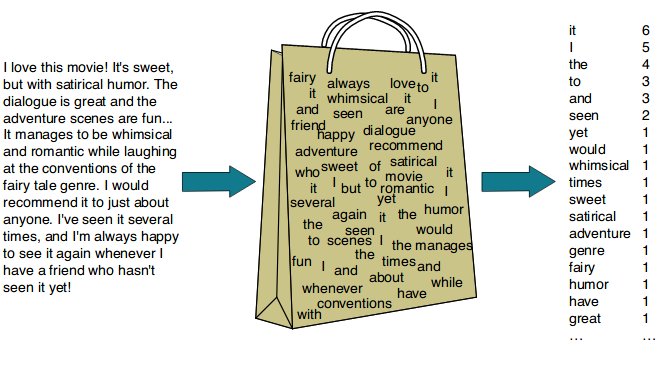

**Usando a técnica Saco de palavras**

In [ ]:
# importando o CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer
# instanciando o CountVectorizer, binary=True faz a codificacao binaria dos nossos dados 
vectorizer = CountVectorizer(binary=True, max_features=5000)
texto = df['review_comment_message']
# vetorizando o texto
X_bow = vectorizer.fit_transform(texto)
#visualizando
X_bow.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

**Usando a técnica Tfidf**

In [ ]:
#importando o tfidf
from sklearn.feature_extraction.text import TfidfVectorizer
# instanciando o TfidfVectorizer
tfidf_vect = TfidfVectorizer(max_features=5000)
# vetorizando o texto
X_tfidf = tfidf_vect.fit_transform(texto)
#visualizando
print(X_tfidf)

  (0, 1776)	0.6912419975120544
  (0, 3566)	0.3057310151554017
  (0, 256)	0.3519620085923513
  (0, 552)	0.427475163402942
  (0, 3871)	0.3494292151907997
  (1, 3760)	0.4764293672452992
  (1, 1945)	0.30265959217069316
  (1, 4595)	0.21277836158522206
  (1, 3733)	0.3234264741088515
  (1, 4249)	0.33055315514783556
  (1, 2421)	0.31225318643877553
  (1, 968)	0.12987438187952968
  (1, 85)	0.2167014983184713
  (1, 2530)	0.20605256981033698
  (1, 2631)	0.1699531136764762
  (1, 3221)	0.43542721130488277
  (2, 4811)	0.18398933705086712
  (2, 1121)	0.16713190526958613
  (2, 424)	0.29764891459629156
  (2, 3003)	0.23904097248300465
  (2, 3180)	0.14699696654934277
  (2, 834)	0.0954458220313944
  (2, 2311)	0.29505074167087586
  (2, 2728)	0.4032971988301842
  (2, 4346)	0.14994492554291153
  :	:
  (42386, 3472)	0.16617746900671274
  (42386, 2689)	0.21688634967175516
  (42386, 129)	0.161732368643178
  (42386, 1964)	0.15572093087040983
  (42386, 1655)	0.3352727358053245
  (42386, 4787)	0.20350940031967366
 

**Separação dos dados de treino e teste**

Antes de criar o nosso classificador precisamos dividir os dados em base de treino (70%) e teste (30%) essa é uma recomendação básica.
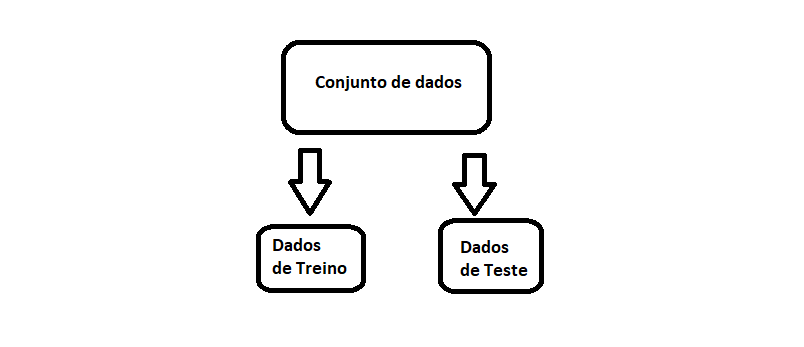 

In [ ]:
#importando o recurso de treino e teste 
from sklearn.model_selection import train_test_split
#separação de dados vetorizados usando saco de palavras
X1_train, X1_test, y1_train, y1_test = train_test_split(X_bow, df['sentimento'],
                                                    test_size=0.3, random_state = 10)
#separação de dados vetorizados usando tfidf   
X2_train, X2_test, y2_train, y2_test = train_test_split(X_tfidf, df['sentimento'],
                                                        test_size=0.3, random_state = 10)



# Métricas de classificação

Para avaliar nosos modelo vamos construir uma função onde podemos aplicar e visualizar as métricas dada abaixo:
1. accuracy_score ( score de acuracia )
2. confusion_matrix (matriz de confusão)
3. f1_score, 
4. roc_auc_score ( curva AUC )


In [ ]:
#importando as métricas que serão usadas para avaliação do nosso modelo de classificação:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_auc_score

In [ ]:
#função para visualizar as métricas do modelo 
def visualizar_metricas(y_true, y_pred):
  print("Acurácia: ", accuracy_score(y_true, y_pred))
  print("\nAUROC:", roc_auc_score(y_true, y_pred))
  print("\nF1-Score:", f1_score(y_true, y_pred, average='weighted'))
  print("\nMatriz de confusão:")
  sns.heatmap(confusion_matrix(y_true, y_pred), annot=True)
  plt.show()

# **Construção de um classificador Naive Bayes**
O modelo escolhido foi o classificador [multinomial Naïve Bayes](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html),este mesmo é adequado para classificação com características discretas (por exemplo, contagem de palavras para classificação em um texto) dado pela seguinte fórmula:

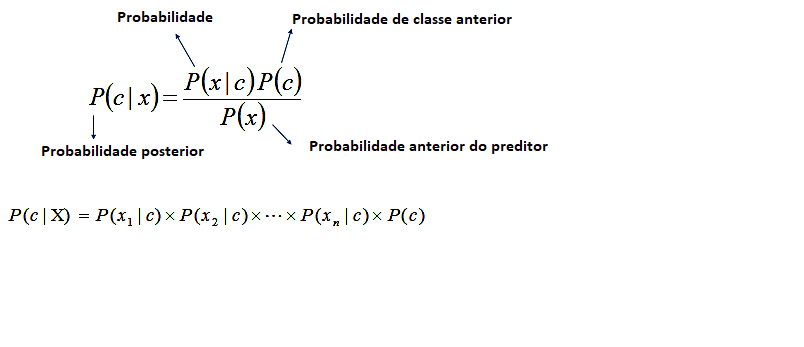

In [ ]:
#importando o classificador multinomial naive bayes
from sklearn.naive_bayes import MultinomialNB

**Usando o saco de palavras**

Acurácia:  0.8781945427380672

AUROC: 0.8651054979802435

F1-Score: 0.8781199690316176

Matriz de confusão:


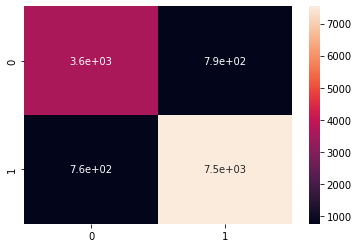

In [ ]:

nb1 = MultinomialNB() # carregando o modelo 

nb1.fit(X1_train.toarray(), y1_train) # treinando o modelo

y1_gnb_pred = nb1.predict(X1_test.toarray()) # prevendo resultados

visualizar_metricas(y1_test, y1_gnb_pred) # imprimindo o resultado

**Usando a técnica tifdif**

Acurácia:  0.8802390500904301

AUROC: 0.8656680002639563

F1-Score: 0.8799561786384799

Matriz de confusão:


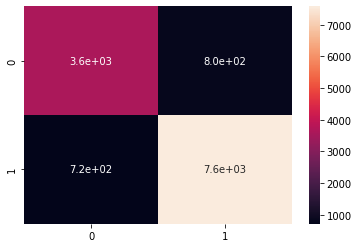

In [ ]:

nb2 = MultinomialNB()

nb2.fit(X2_train.toarray(), y2_train)

y2_gnb_pred = nb2.predict(X2_test.toarray())

visualizar_metricas(y2_test, y2_gnb_pred)

Analisando as métricas do modelo, vimos que o o segundo se saiu muito bem usando a técnica de tifdif com uma acuracia de 88%.

Vamos validar isso usando uma **função** para gerar novas previsões 

In [ ]:
def nova_previsao(texto):
  '''Funcao para fazer nova previsão'''
  texto_vetor = tfidf_vect.transform([texto]) # usando o texto vetorizado 
  y1_gnb_pred = nb1.predict(texto_vetor) # gerando novas previsões 

  if y1_gnb_pred == 0: # se o sentimento for negativo mostre na tela 
    print("Essa é uma review negativa.")
  else: # senão retorne para mim um sentimento positivo 
    print("Essa é uma review positiva.")

In [ ]:
nova_previsao("Nossa que produto que produto lindo") # passando um novo comentário para nosso modelo 

Essa é uma review positiva.


# **Conclusões finais**

A modelagem preditiva foi considerada mediana uma vez que, selecionamos apenas um modelo de classificação, este mesmo foi selecionado devido a sua acurancia e performance muito bem nesse tipo de problema embora, existe outros modelos a serem testados para assim, chegar em uma alta performace nos resultados.

Portanto, apresenta também limitações na modelagem pois também estamos em um **contexto de E-commerce** desse modo, para cada tipo de contexto é necessário saber bem escolher um algortimo de classificação.

# **Referências**

1. Curso Classificação de sentimentos com spaCy 1 - IA Expert Academy
2. https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html
3. KUHN, Max; JOHNSON, Kjell. Feature engineering and selection: A practical approach for predictive models. CRC Press, 2019.
4. https://www.analyticsvidhya.com/blog/2020/02/quick-introduction-bag-of-words-bow-tf-idf/